# Stanford CME 241 (Winter 2021) - Assignment 3

## Question 3

### Part 1

Using notation from **RLForFinanceBook**, 

$$\mathcal{S} = \{0, 1, ..., n\}$$
$$\mathcal{N} = \{1, 2, ..., n-1\}$$
$$\mathcal{A} = \{A, B\}$$
$$\mathcal{P}(s,a,s') = \mathbb{P}\left[S_{t+1} = s' | S_t = s, A_t = a\right]: \forall s \in \mathcal{N}, s' \in \mathcal{S}$$

We can be more specific about $\mathcal{P}(s,a,s')$:

$$\mathcal{P}(s,A,s-1) = \frac{s}{n}$$
$$\mathcal{P}(s,A,s+1) = \frac{n-s}{n}$$
$$\mathcal{P}(s,B,s') = \frac{1}{n} : \forall s' \neq s$$

To solve the *frog-escape* problem using an MDP Optimal Value Function, we want to reward the frog (agent) for reaching lily $n$ and escaping the pond. By setting a reward of +1 for escaping, and a reward of 0 for all other states, the optimal value function will have a nice physical interpretation. $V^*(s)$ will represent the frog's escape probability at state $s$.

Mathematically, this means the rewards should be defined as:
$$\mathcal{R}(n) = +1$$
$$\mathcal{R}(0) = 0$$
$$\mathcal{R}(s) = 0 : \forall s \in \mathcal{N}$$


### Part 2

In [1]:
from typing import Iterable, Generator

from itertools import product

from rl.distribution import Categorical, Choose, Constant
from rl.markov_process import StateReward
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.markov_decision_process import FinitePolicy

In [2]:
def get_frog_mdp(n: int) -> FiniteMarkovDecisionProcess:
    """Construct the frog-problem MDP for a given n."""
    
    _rewards = {s: 0 for s in range(n)}
    _rewards[n] = +1
    
    def _get_state_rewards(state: int, action: str) -> StateReward:
        """Return the distribution of rewards."""
        if action == 'A':
            return Categorical({
                (state - 1, _rewards[state - 1]): state / n,
                (state + 1, _rewards[state + 1]): (n - state) / n
            })
        if action == 'B':
            return Choose({
                (i, _rewards[i]) for i in range(n + 1) if i != state
            })
        raise RuntimeError(f"Uh oh, should not be reaching here!")
    
    actions = 'AB'
    state_action_mapping = {0: None, n: None}
    for s in range(1, n):
        state_action_mapping[s]= {}
        for a in actions:
            state_action_mapping[s][a] = _get_state_rewards(s, a)
    return FiniteMarkovDecisionProcess(state_action_mapping)

In [3]:
def frog_policies(n: int) -> Generator:
    """Yield all possible deterministic policies."""
    for i in product('AB', repeat=n-1):
        policy_map = {
            state: Constant(action) 
            for state, action in enumerate(i, start=1)
        }
        policy_map[0] = None
        policy_map[n] = None
        yield FinitePolicy(policy_map)

In [4]:
n = 3

mdp = get_frog_mdp(n)
for i, pol in enumerate(frog_policies(n), start=1):
    mrp = mdp.apply_finite_policy(pol)
    print(f"Policy #{i} has V* = {mrp.get_value_function_vec(gamma=1)}")

Policy #1 has V* = [0.4 0.6]
Policy #2 has V* = [0.28571429 0.42857143]
Policy #3 has V* = [0.57142857 0.71428571]
Policy #4 has V* = [0.5 0.5]


Policy #3 is clearly the optimal deterministic policy.

## Part 3

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

In [6]:
def get_optimal_policy(
    n: int, 
    mdp: FiniteMarkovDecisionProcess
) -> FinitePolicy:
    """Compare all deterministic policies and return optimal one."""
    optimal_policy = None
    v_star = None
    for pol in frog_policies(n):
        mrp = mdp.apply_finite_policy(pol)
        vf = mrp.get_value_function_vec(gamma=1)
        if optimal_policy is None or (vf > v_star).all():
            optimal_policy = pol
            v_star = vf
    return optimal_policy

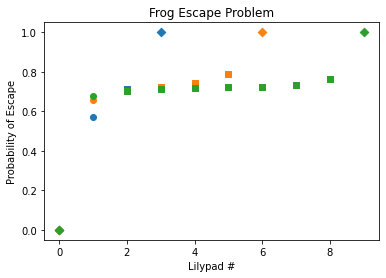

In [7]:
colors = ["tab:blue", "tab:orange", "tab:green"]
markers = ["s", "o", "D"]

for i, n in enumerate([3, 6, 9]):
    mdp = get_frog_mdp(n)
    policy = get_optimal_policy(n, mdp)
    mrp = mdp.apply_finite_policy(policy)
    v_star = mrp.get_value_function_vec(gamma=1)
    plt.scatter(0, 0, color=colors[i], marker=markers[2])
    for j, s in enumerate(range(1, n)):
        action = policy.act(s).value
        markers_ = {'A': 0, 'B': 1}
        plt.scatter(s, v_star[j], color=colors[i], marker=markers[markers_[action]])
    plt.scatter(n, 1, color=colors[i], marker=markers[2])
    
plt.title("Frog Escape Problem")
plt.ylabel("Probability of Escape")
plt.xlabel("Lilypad #")
plt.show()

In the above graph, the colors correspond to different "size" *frog-problems*. The diamonds represent terminal states, the circles represent states where the optimal action is **B** and the squares are states where the optimal action is **A**. Its clear that the only state where choosing **B** is optimal is in state 1.